# Author: 
Seyd Ali Hosseini (student number: 11023432)

# Supervisor:
Prof. Kutz



## Modeling from Measurements: Course Homework

In this study, I will test various combinations of methods discussed in our course, including Singular Value Decomposition (SVD), Dynamic Mode Decomposition (DMD), Sparse Identification of Nonlinear Dynamical Systems (SINDy), and SHRED. Additionally, I will explore several machine learning algorithms, such as XGBoost, Random Forest, Logistic Regression, and K-Neighbors Classifier, on my dataset. The goal of this analysis is to gain a deeper understanding of the data and its implications for future analyses.


# Import Needed Libraries

In this section, I import the necessary Python libraries required for data analysis, modeling, and visualization. These libraries provide essential tools for handling datasets, performing mathematical computations, and implementing various machine learning and statistical techniques. Below are the libraries I am importing:

- **Pandas**: For data manipulation and analysis.
- **NumPy**: For numerical computations and working with arrays.
- **Matplotlib**: For data visualization and plotting.
- **Seaborn**: For statistical data visualization.
- **Scikit-learn**: For machine learning algorithms and tools.
- **Statsmodels**: For statistical modeling and hypothesis testing.
- **PyDMD**: For Dynamic Mode Decomposition analysis.
- **PySINDy**: For Sparse Identification of Nonlinear Dynamical Systems.
- **XGBoost**: For implementing gradient boosting algorithms.
- **Others**: Any additional libraries that may be relevant for specific tasks.

By organizing these imports at the beginning of the notebook, I ensure that all necessary dependencies are readily available for subsequent analysis and modeling steps.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import numpy as np
import seaborn as sns
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from pydmd import DMD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pysindy as ps
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import torch
import torch.nn as nn
import warnings
import torch.optim as optim
warnings.filterwarnings("ignore")

# What is My Data

My dataset consists of daily candlestick (OHLCV) data from the Carbon Emission market, covering the period from 2018 to mid-2023. This data includes Open, High, Low, Close, and Volume values, which are crucial for understanding market trends and dynamics. To provide a better visualization of the data, I have included a graphical representation below.

# Load Data

In this step, I load the source data into my environment and visualize it. This allows me to inspect the dataset and understand its structure, ensuring that it is ready for further analysis and modeling.


            Volume  Open  High       Low  Close
Date                                           
2018-01-02    8944  8.05  8.13  7.730000   7.79
2018-01-03    7528  7.75  7.97  7.730000   7.82
2018-01-04    7649  7.89  7.92  7.740000   7.76
2018-01-05    5342  7.75  7.84  7.740000   7.78
2018-01-08   12789  7.76  7.92  7.609231   7.67


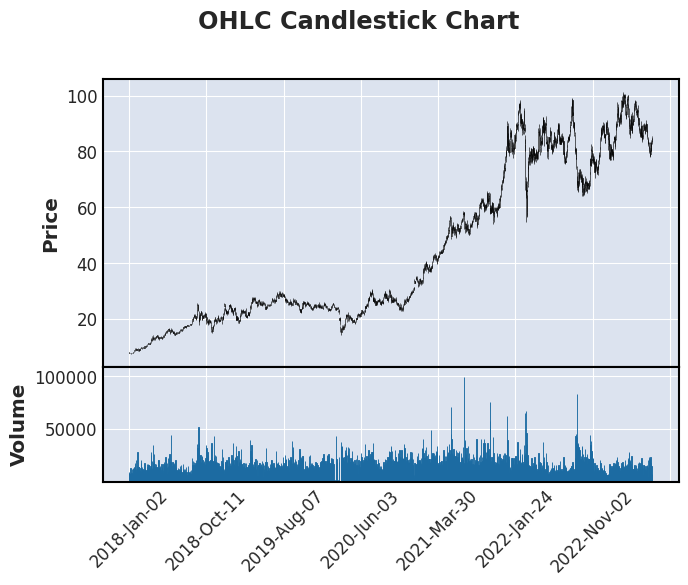

In [2]:
path = r'data/test5_1d.csv'
data = pd.read_csv(path, index_col=0) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True, drop=True)

print(data.head())

mpf.plot(data, type='candle', volume=True, title='OHLC Candlestick Chart')


To gain a clearer understanding of each element, I plotted them in separate figures.


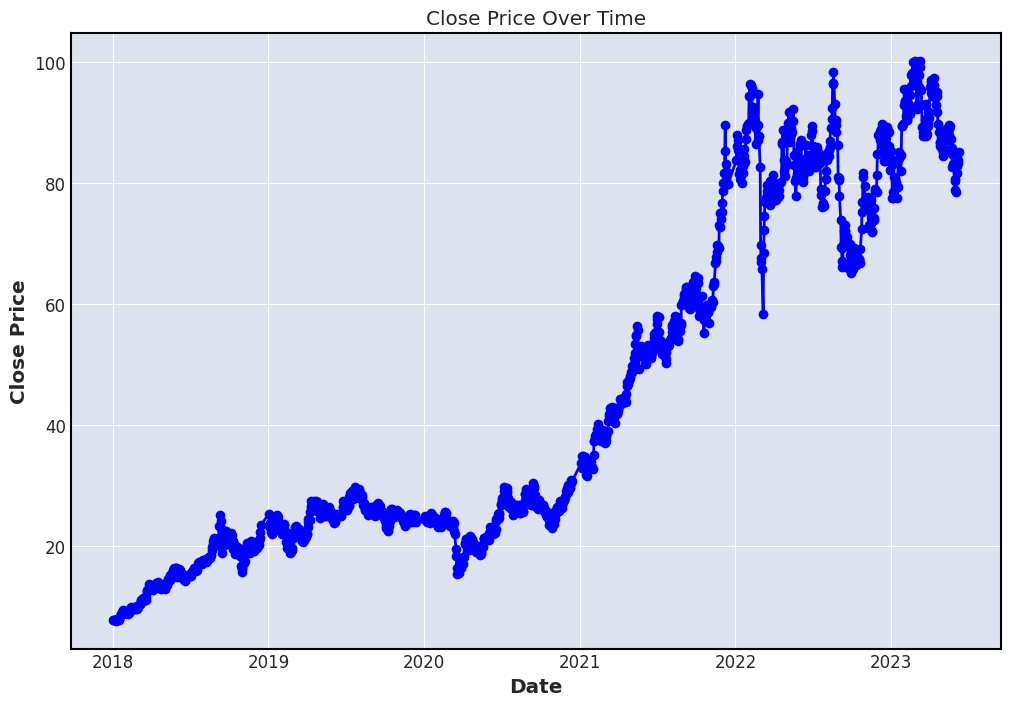

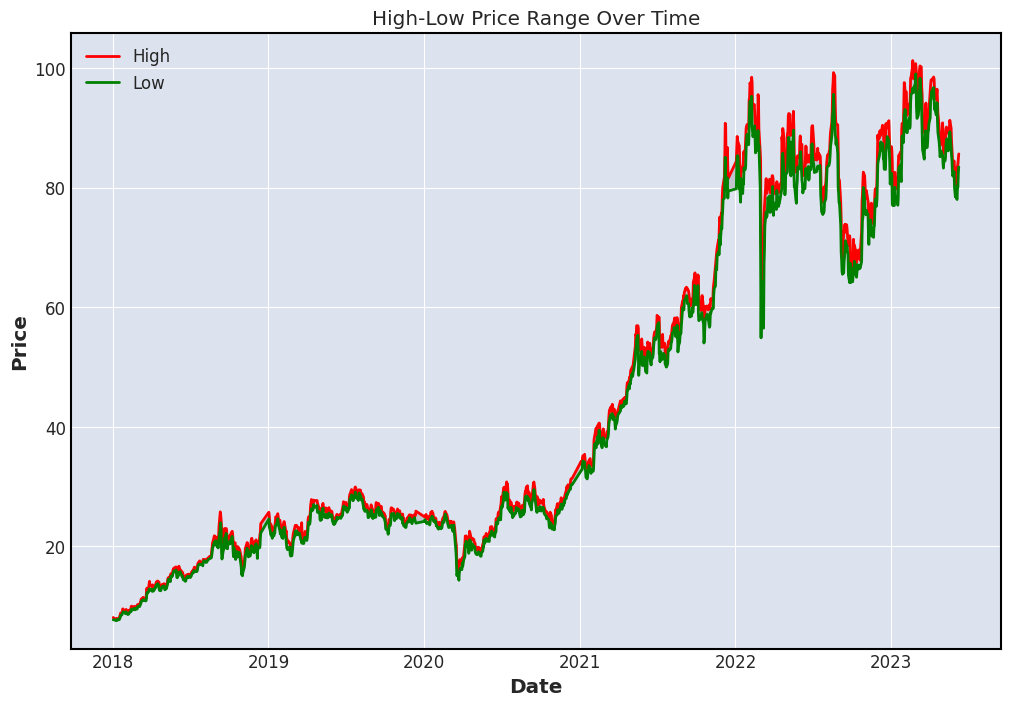

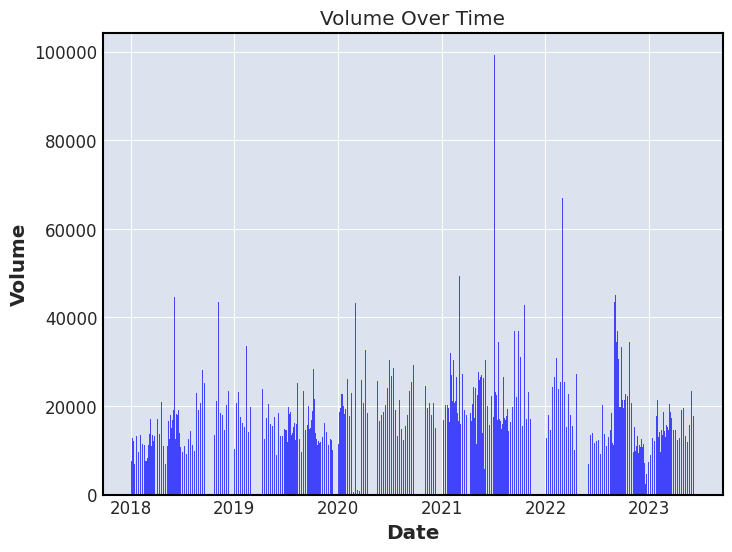

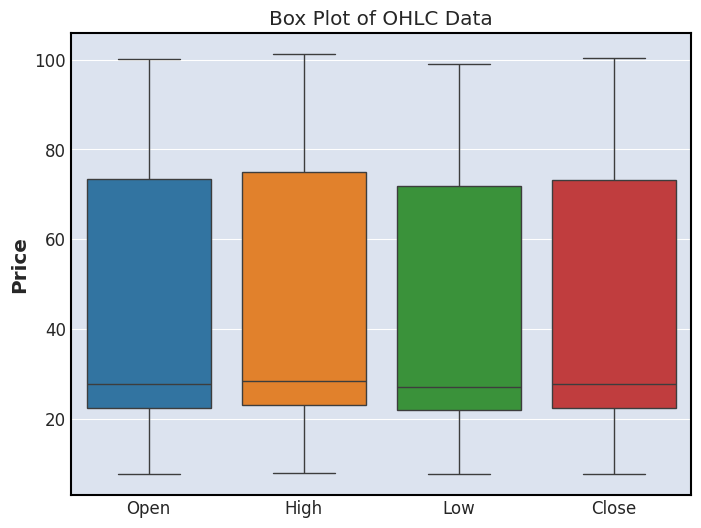

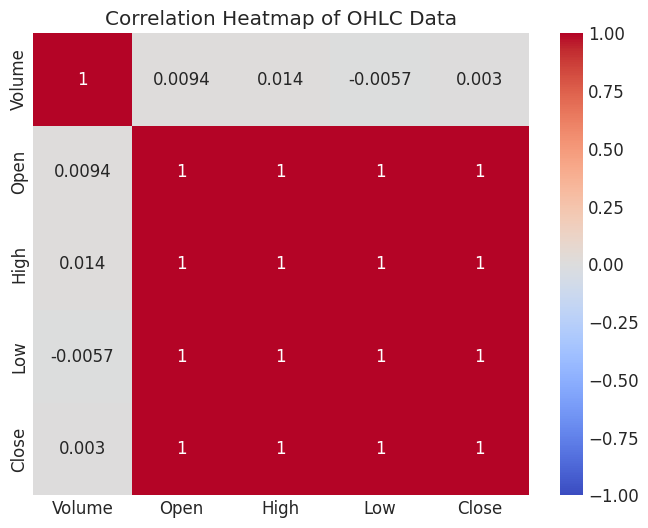

In [3]:
# Line plot for Close price
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Close'], marker='o', linestyle='-', color='b')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# High-Low range plot
plt.figure(figsize=(12, 8))
plt.fill_between(data.index, data['Low'], data['High'], color='gray', alpha=0.3)
plt.plot(data.index, data['High'], color='r', label='High')
plt.plot(data.index, data['Low'], color='g', label='Low')
plt.title('High-Low Price Range Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



# Check if 'Volume' exists in your dataset
if 'Volume' in data.columns:
    plt.figure(figsize=(8, 6))
    plt.bar(data.index, data['Volume'], color='blue', alpha=0.7)
    plt.title('Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.show()


# Box plot for OHLC values
plt.figure(figsize=(8,6))
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close']])
plt.title('Box Plot of OHLC Data')
plt.ylabel('Price')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of OHLC Data')
plt.show()


It is evident that the Open, High, Low, and Close prices exhibit a strong correlation with one another. Therefore, I can focus solely on the Close price and eliminate the other variables from my analysis.


In [4]:
data.drop(columns=['Open', 'High', 'Low'], inplace=True)

# Add Features

To enhance the dataset, I incorporated several well-known analytical features, including Moving Averages, the Moving Average Convergence Divergence (MACD), Bollinger Bands, and the Relative Strength Index (RSI). These features are essential for improving the analysis and understanding of market trends.


            Volume      Close       MA60        MA7       MA15       MA30  \
Date                                                                        
2018-03-26   13135  12.950000   9.622167  12.050000  11.500667  10.672410   
2018-03-27   19922  13.650476   9.719841  12.402925  11.712698  10.797426   
2018-03-28   34621  13.020000   9.806508  12.682925  11.872032  10.911093   
2018-03-29   13901  13.320000   9.899174  12.935782  12.021365  11.036759   
2018-04-03   17698  13.300000   9.991174  13.028639  12.168032  11.161426   
...            ...        ...        ...        ...        ...        ...   
2023-06-05   23218  82.860000  88.995514  81.091429  84.277778  85.570000   
2023-06-06   17637  81.640000  88.686681  80.878571  83.791778  85.397667   
2023-06-07   17777  83.860000  88.492972  81.001429  83.513111  85.318333   
2023-06-08   15161  83.350000  88.334306  81.425714  83.093111  85.207333   
2023-06-09    7723  85.126250  88.265910  82.046607  82.806194  85.123208   

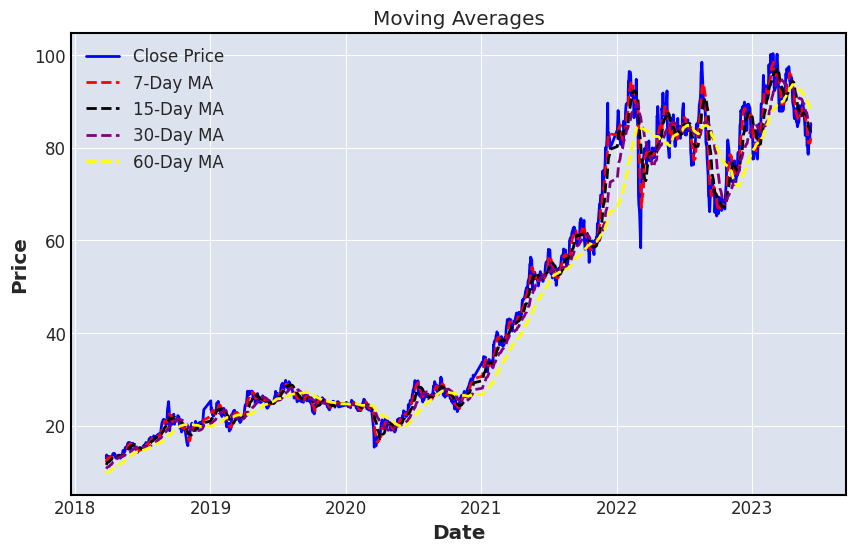

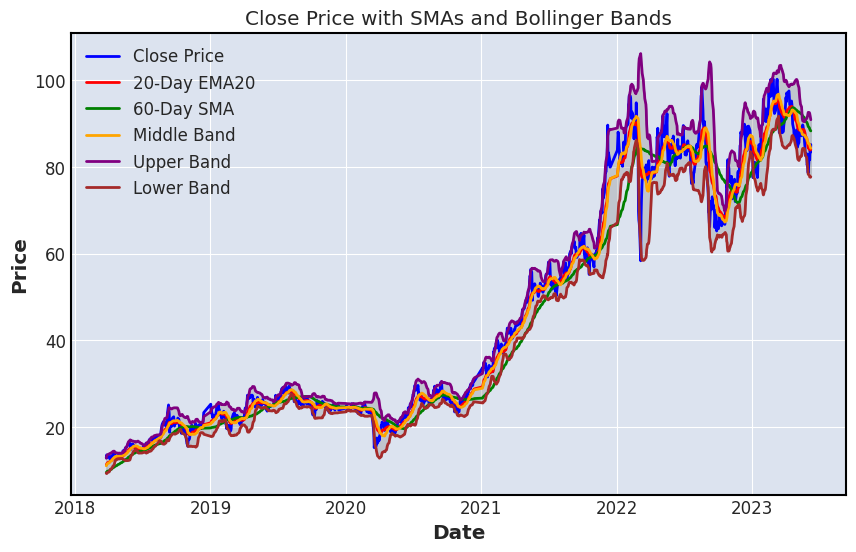

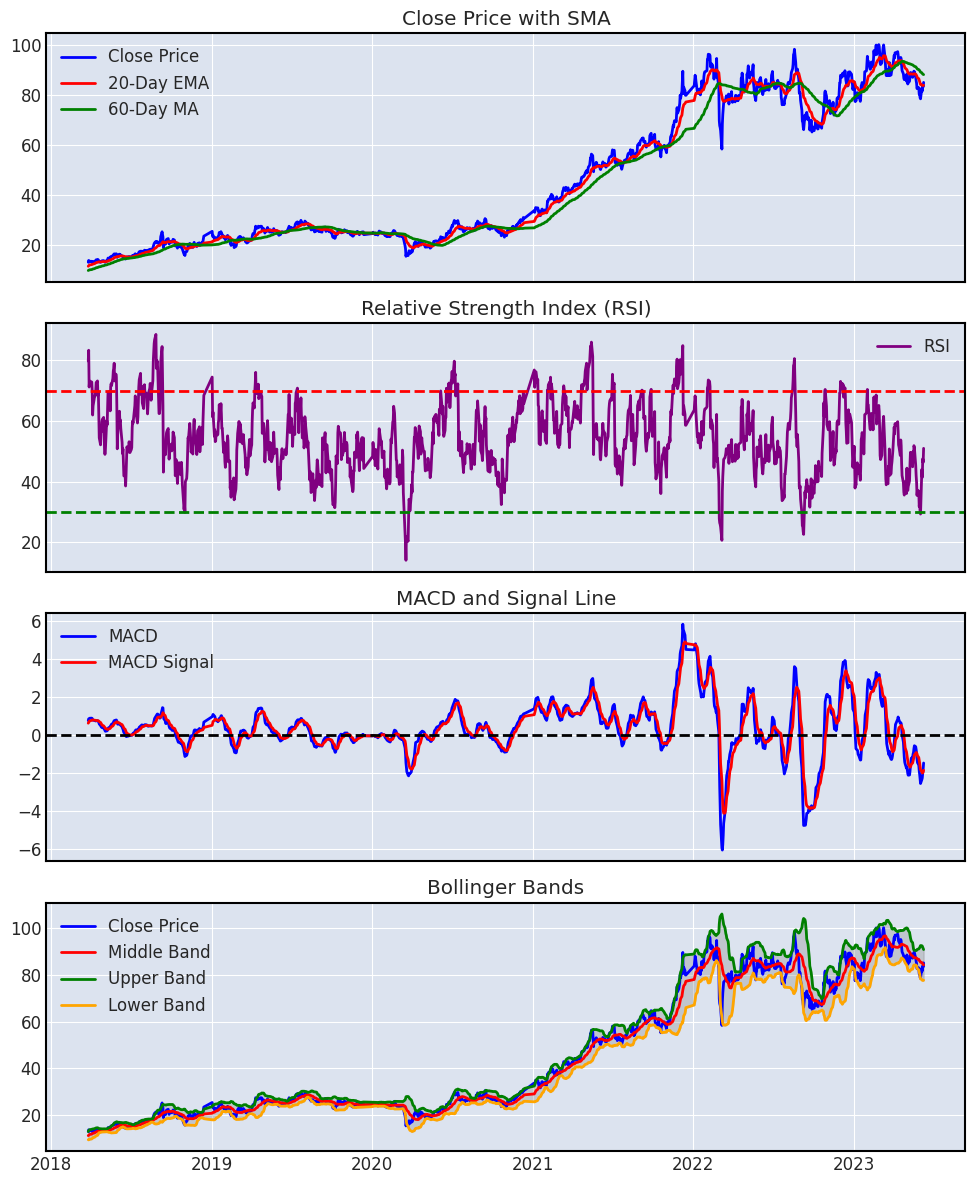

In [5]:
data['MA60'] = data['Close'].rolling(window=60).mean()
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA15'] = data['Close'].rolling(window=15).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.rsi(data['Close'], length=14)
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
data['MACD'] = macd['MACD_12_26_9']
data['MACD_signal'] = macd['MACDs_12_26_9']
bbands = ta.bbands(data['Close'], length=20, std=2)
data['BB_Middle'] = bbands['BBM_20_2.0']  # Middle Band
data['BB_Upper'] = bbands['BBU_20_2.0']   # Upper Band
data['BB_Lower'] = bbands['BBL_20_2.0']   # Lower Band
data.dropna(inplace=True)
print(data)


# Plot Close price and moving average
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='b')
plt.plot(data.index, data['MA7'], label='7-Day MA', color='r', linestyle='--')
plt.plot(data.index, data['MA15'], label='15-Day MA', color='black', linestyle='--')
plt.plot(data.index, data['MA30'], label='30-Day MA', color='purple', linestyle='--')
plt.plot(data.index, data['MA60'], label='60-Day MA', color='yellow', linestyle='--')
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='b')
plt.plot(data.index, data['EMA20'], label='20-Day EMA20', color='r')
plt.plot(data.index, data['MA60'], label='60-Day SMA', color='g')
plt.plot(data.index, data['BB_Middle'], label='Middle Band', color='orange')
plt.plot(data.index, data['BB_Upper'], label='Upper Band', color='purple')
plt.plot(data.index, data['BB_Lower'], label='Lower Band', color='brown')
plt.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='gray', alpha=0.3)
plt.title('Close Price with SMAs and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()




fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot Close price with SMA
axs[0].plot(data.index, data['Close'], label='Close Price', color='b')
axs[0].plot(data.index, data['EMA20'], label='20-Day EMA', color='r')
axs[0].plot(data.index, data['MA60'], label='60-Day MA', color='g')
axs[0].set_title('Close Price with SMA')
axs[0].legend()
axs[0].grid(True)

# Plot RSI
axs[1].plot(data.index, data['RSI'], label='RSI', color='purple')
axs[1].axhline(70, color='red', linestyle='--')
axs[1].axhline(30, color='green', linestyle='--')
axs[1].set_title('Relative Strength Index (RSI)')
axs[1].legend()
axs[1].grid(True)

# Plot MACD
axs[2].plot(data.index, data['MACD'], label='MACD', color='b')
axs[2].plot(data.index, data['MACD_signal'], label='MACD Signal', color='r')
axs[2].axhline(0, color='black', linestyle='--')
axs[2].set_title('MACD and Signal Line')
axs[2].legend()
axs[2].grid(True)

# Plot Bollinger Bands
axs[3].plot(data.index, data['Close'], label='Close Price', color='b')
axs[3].plot(data.index, data['BB_Middle'], label='Middle Band', color='r')
axs[3].plot(data.index, data['BB_Upper'], label='Upper Band', color='g')
axs[3].plot(data.index, data['BB_Lower'], label='Lower Band', color='orange')
axs[3].fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='gray', alpha=0.3)
axs[3].set_title('Bollinger Bands')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

# Label Calculation

This project focuses on classifying the next step in the price trend based on previous movements. In this step, I calculated the target labels by assessing the difference between the future price and the current price. A price increase is labeled as Up (+1), while a price decrease is labeled as Down (0).


In [6]:
data['target'] = data['Close'] - data['Close'].shift(-1)
data['target'] = (data['target'] > 0).astype(int)
data.dropna(inplace=True)

print(data.head())

            Volume      Close      MA60        MA7       MA15       MA30  \
Date                                                                       
2018-03-26   13135  12.950000  9.622167  12.050000  11.500667  10.672410   
2018-03-27   19922  13.650476  9.719841  12.402925  11.712698  10.797426   
2018-03-28   34621  13.020000  9.806508  12.682925  11.872032  10.911093   
2018-03-29   13901  13.320000  9.899174  12.935782  12.021365  11.036759   
2018-04-03   17698  13.300000  9.991174  13.028639  12.168032  11.161426   

                EMA20        RSI      MACD  MACD_signal  BB_Middle   BB_Upper  \
Date                                                                            
2018-03-26  11.323217  79.800600  0.776014     0.637313  11.162500  12.901176   
2018-03-27  11.544861  83.348003  0.865848     0.683020  11.337024  13.321505   
2018-03-28  11.685350  71.223704  0.876068     0.721630  11.483024  13.511160   
2018-03-29  11.841031  73.219933  0.898024     0.756908  11.64

# Data Normalization

To achieve a better distribution of the data, I applied the min-max normalization method. This technique rescales the data to a fixed range, ensuring that all features contribute equally to the analysis.

In [7]:
for column in list(data.columns):

    min = data[column].min()
    max = data[column].max()
    data[column] = (data[column] - min) / (max - min)

print(data.head())

              Volume     Close      MA60       MA7      MA15      MA30  \
Date                                                                     
2018-03-26  0.126773  0.003082  0.000000  0.000000  0.000000  0.000000   
2018-03-27  0.195540  0.011077  0.001163  0.004085  0.002475  0.001478   
2018-03-28  0.344472  0.003881  0.002196  0.007326  0.004334  0.002821   
2018-03-29  0.134534  0.007305  0.003299  0.010253  0.006077  0.004307   
2018-04-03  0.173006  0.007077  0.004395  0.011328  0.007789  0.005781   

               EMA20       RSI      MACD  MACD_signal  BB_Middle  BB_Upper  \
Date                                                                         
2018-03-26  0.000000  0.882223  0.573366     0.525460   0.000000  0.000000   
2018-03-27  0.002623  0.929866  0.580917     0.530525   0.002040  0.004511   
2018-03-28  0.004285  0.767030  0.581776     0.534804   0.003746  0.006547   
2018-03-29  0.006127  0.793841  0.583621     0.538713   0.005692  0.008645   
2018-04-03  0

# Plot Correlation Heatmap

After completing the preprocessing steps, I plotted a correlation heatmap to visualize the relationships between the features in the dataset for each day. This heatmap helps identify which features are strongly correlated and can provide insights for further analysis.


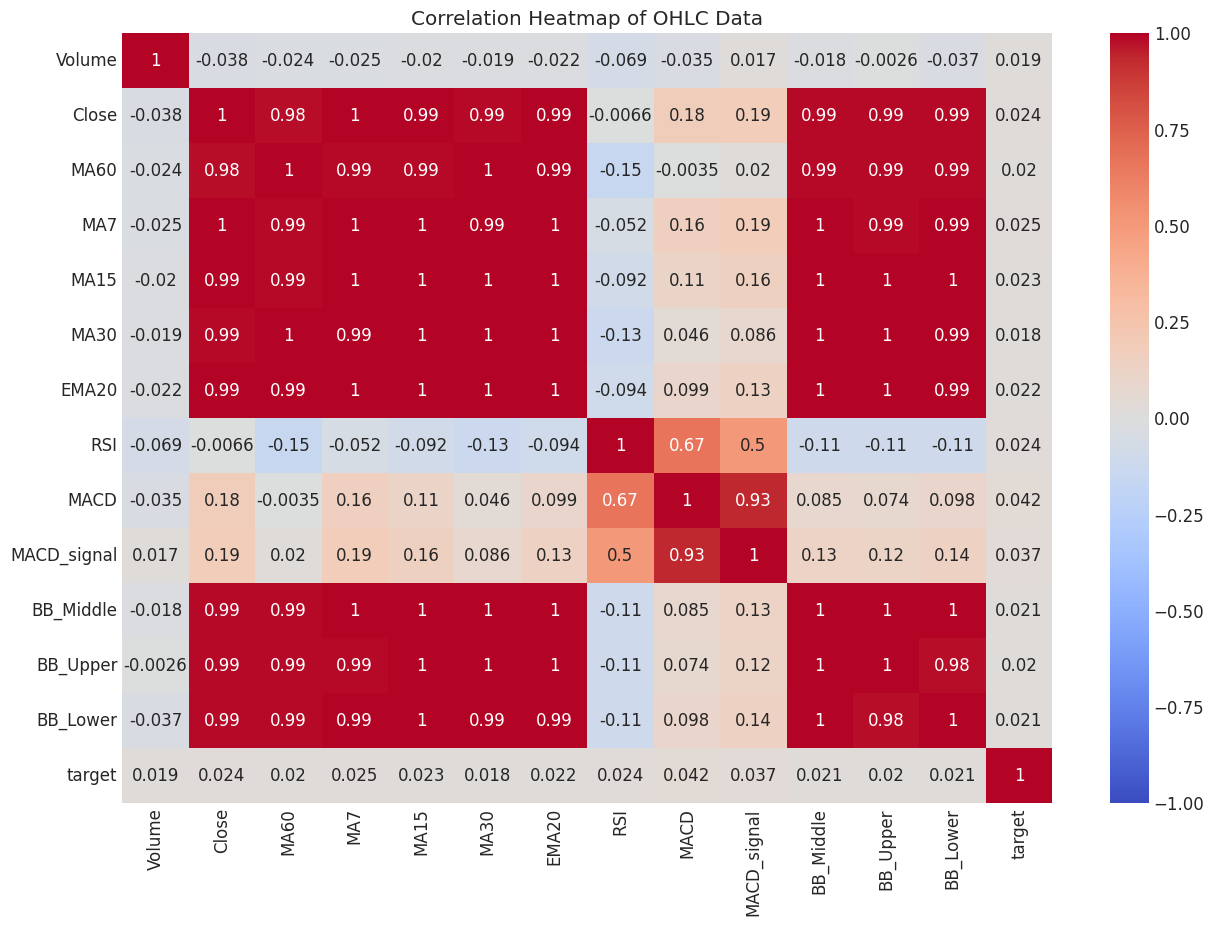

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of OHLC Data')
plt.show()

💡 As evident from the heatmap, the addition of new features has resulted in a decrease in feature correlation. This reduction in correlation indicates that the new features contribute unique information, enhancing the overall quality of the dataset for analysis.


# Train and Test Separation

Next, I separated my dataset into training and testing sets to facilitate future analyses. This division allows me to evaluate the model's performance on unseen data, ensuring that the results are robust and generalizable.


In [9]:
x = data.drop(columns=['target']).values # Features
y = data['target'].values  # Target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Shape of x_train is:  ', len(x_train))
print('Shape of y_train is:  ', len(y_train))
print('Shape of x_train is:  ', len(x_test))
print('Shape of y_test is:  ', len(y_test))

Shape of x_train is:   1036
Shape of y_train is:   1036
Shape of x_train is:   260
Shape of y_test is:   260


# Machine Learning Models

To evaluate my data at each step, I need to implement functions for various machine learning algorithms. This allows me to apply different models to different stages of the dataset and assess their performance effectively.


In [11]:
def MLModelTest(x_train, y_train, x_test, y_test):
    results = {}
    models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),

    'KNN': KNeighborsClassifier(n_neighbors=5)
        }


    for model_name, model in models.items():
        # Train the model
        model.fit(x_train, y_train)

        # Predict on x_test
        y_test_pred = model.predict(x_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, y_test_pred)
        class_report = classification_report(y_test, y_test_pred, output_dict=True)

        # Store results in dictionary
        results[model_name] = {
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "classification_report": class_report
        }

        # Print performance metrics
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        print(f"Classification Report:\n {classification_report(y_test, y_test_pred)}")

    # Visualize comparison results
    model_names = list(results.keys())
    accuracies = [results[model]["accuracy"] for model in model_names]
    roc_aucs = [results[model]["roc_auc"] for model in model_names]

    # Plot Accuracy and ROC-AUC Score
    plt.figure(figsize=(15,6))

    # Accuracy Bar Plot
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracies, color='skyblue')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')

    # ROC-AUC Score Bar Plot
    plt.subplot(1, 2, 2)
    plt.bar(model_names, roc_aucs, color='salmon')
    plt.title('Model ROC-AUC Score Comparison')
    plt.xlabel('Models')
    plt.ylabel('ROC-AUC Score')

    plt.tight_layout()
    plt.show()

Initially, I employed machine learning models to evaluate my source data, gaining a preliminary understanding of the accuracy before applying new methods.



Model: Logistic Regression
Accuracy: 0.5385
ROC-AUC Score: 0.5286
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.95      0.68       133
         1.0       0.68      0.10      0.18       127

    accuracy                           0.54       260
   macro avg       0.61      0.53      0.43       260
weighted avg       0.60      0.54      0.43       260


Model: Random Forest
Accuracy: 0.5154
ROC-AUC Score: 0.5139
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.58      0.55       133
         1.0       0.50      0.45      0.47       127

    accuracy                           0.52       260
   macro avg       0.51      0.51      0.51       260
weighted avg       0.51      0.52      0.51       260


Model: XGBoost
Accuracy: 0.5077
ROC-AUC Score: 0.5055
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.60   

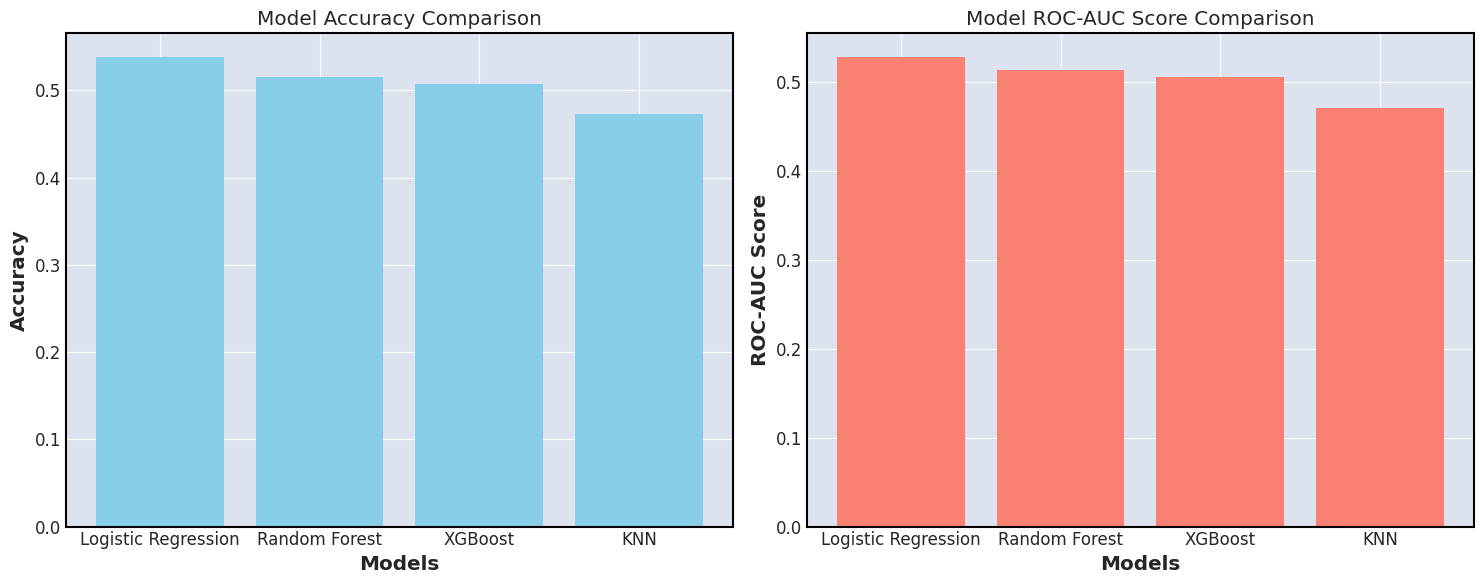

In [12]:
MLModelTest(x_train, y_train, x_test, y_test)

💡

| Model                 | Accuracy (%) | ROC-AUC Score |
|-----------------------|--------------|----------------|
| Logistic Regression    | 53.85        | 52.86          |
| Random Forest          | 51.54        | 51.39          |
| XGBoost                | 50.77        | 50.55          |
| K-Nearest Neighbors    | 47.31        | 47.06          |


The table above presents the accuracy and ROC-AUC scores for various machine learning models applied to the dataset. Among the models evaluated, **Logistic Regression** achieved the highest accuracy of **53.85%**, indicating its effectiveness in predicting the target variable compared to the other models.



# Implementing SVD

To begin, I employed the Singular Value Decomposition (SVD) method to analyze the rank of my data. I visualized both the "Individual Explained Variance by SVD Rank" and the "Cumulative Explained Variance by SVD Rank" to gain a clearer understanding of how much variance is explained by each component and the total variance explained cumulatively.


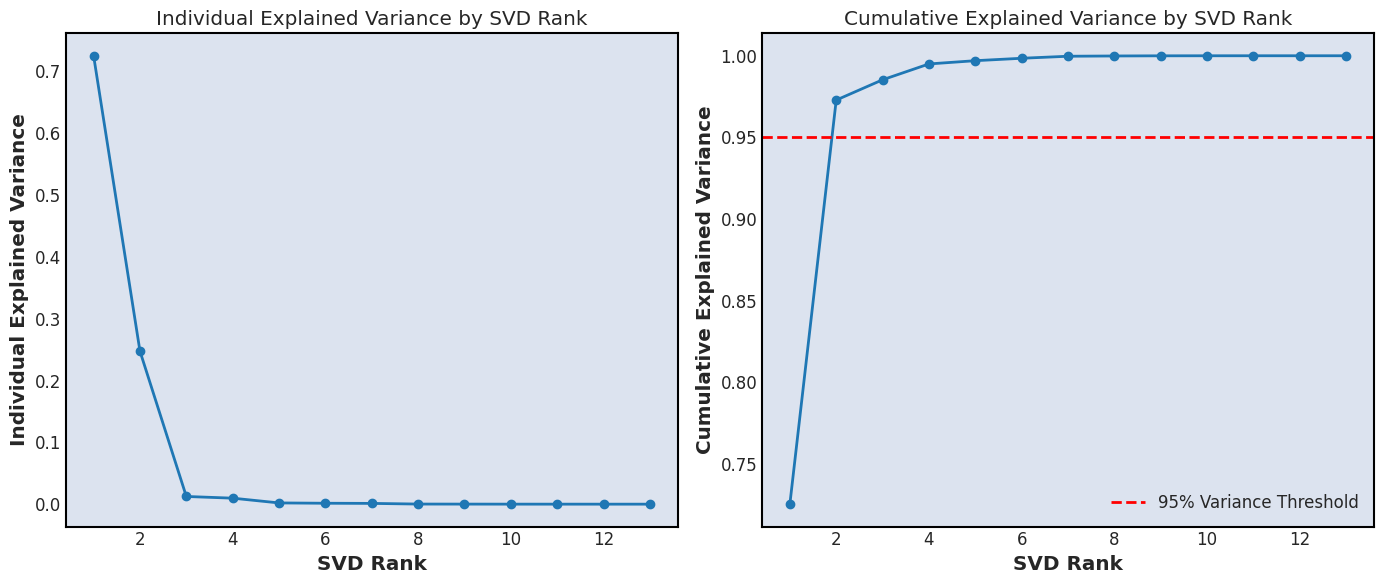

In [13]:
def evaluate_svd_variance(x_train, max_rank=50):
    """
    Evaluates both individual and cumulative explained variance for different SVD ranks.

    Parameters:
    - x_train (numpy array): Training feature matrix
    - max_rank (int): Maximum SVD rank to evaluate

    Returns:
    - None: Displays plots for individual and cumulative explained variance.
    """
    svd = TruncatedSVD(n_components=max_rank)
    svd.fit(x_train)

    # Individual explained variance
    explained_variance = svd.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plotting
    plt.figure(figsize=(14, 6))

    # Individual explained variance
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_rank + 1), explained_variance, marker='o')
    plt.title('Individual Explained Variance by SVD Rank')
    plt.xlabel('SVD Rank')
    plt.ylabel('Individual Explained Variance')
    plt.grid()

    # Cumulative explained variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_rank + 1), cumulative_variance, marker='o')
    plt.title('Cumulative Explained Variance by SVD Rank')
    plt.xlabel('SVD Rank')
    plt.ylabel('Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage:
evaluate_svd_variance(x_train, max_rank=13)

💡

By selecting a rank of 4, it is evident that we can retain over 98% of the information in our dataset. Therefore, I have chosen rank 4 for subsequent analyses.


# Plotting the Correlation Heatmap after SVD

To gain a clearer understanding of our data post-SVD, I plotted the correlation heatmap of the features. The results indicate a significantly reduced correlation among the features compared to the initial dataset, suggesting improved feature independence.


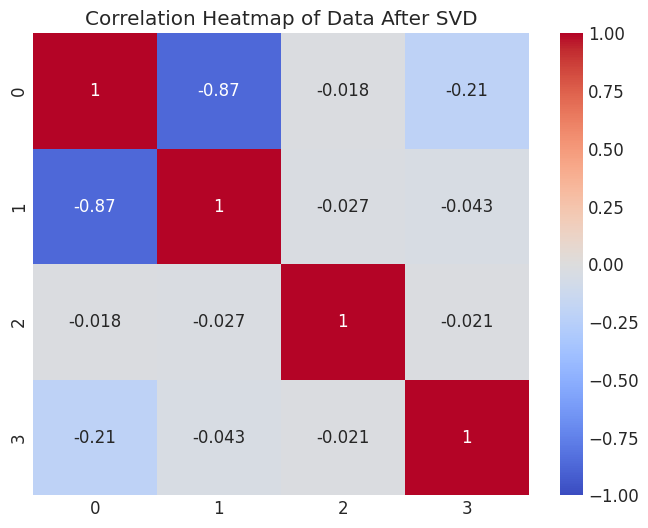

In [16]:
svd = TruncatedSVD(n_components=4)
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)


totalData = list(x_train_svd) + list(x_test_svd)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(totalData).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Data After SVD')
plt.show()

# Testing ML Models' Accuracy after SVD

Next, I will assess the accuracy of various machine learning models after reducing the dimensionality of my data using SVD. This evaluation will provide insights into how the reduction in dimensions impacts model performance.



Model: Logistic Regression
Accuracy: 0.5462
ROC-AUC Score: 0.5361
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.97      0.69       133
         1.0       0.76      0.10      0.18       127

    accuracy                           0.55       260
   macro avg       0.65      0.54      0.43       260
weighted avg       0.65      0.55      0.44       260


Model: Random Forest
Accuracy: 0.5385
ROC-AUC Score: 0.5356
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.66      0.59       133
         1.0       0.54      0.41      0.46       127

    accuracy                           0.54       260
   macro avg       0.54      0.54      0.53       260
weighted avg       0.54      0.54      0.53       260


Model: XGBoost
Accuracy: 0.5077
ROC-AUC Score: 0.5048
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.63   

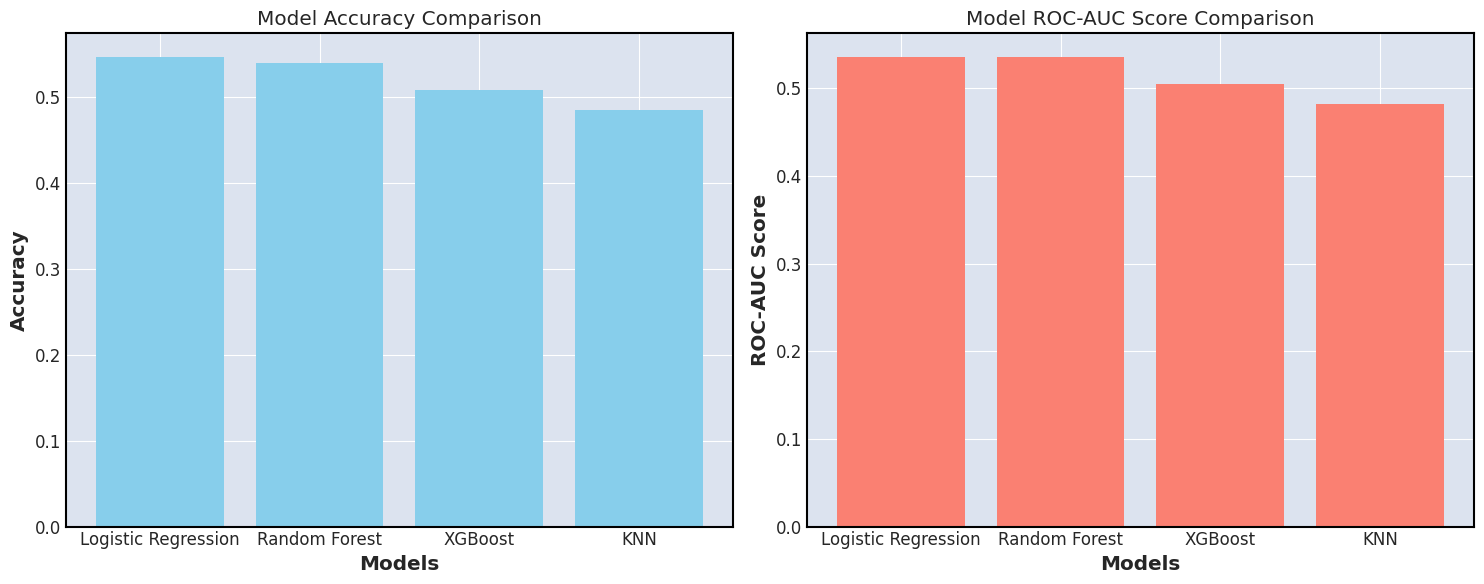

In [17]:
##### according to last evaluation, we selected rank=5 #######


MLModelTest(x_train_svd, y_train, x_test_svd, y_test)


💡


| Model                 | Accuracy (%) Without SVD | Accuracy (%) With SVD |
|-----------------------|--------------------------|-----------------------|
| Logistic Regression    | 53.85                    | 54.62                 |
| Random Forest          | 51.54                    | 53.85                 |
| XGBoost                | 50.77                    | 50.77                 |
| K-Nearest Neighbors    | 47.31                    | 48.46                 |

# Model Accuracy Comparison

The table above presents a comparison of model accuracies before and after applying Singular Value Decomposition (SVD) to the dataset. 

- **Logistic Regression** showed a slight improvement in accuracy from **53.85%** to **54.62%**, indicating that SVD helped enhance its predictive performance.
  
- **Random Forest** also experienced an increase in accuracy, rising from **51.54%** to **53.85%**, suggesting that dimensionality reduction positively impacted its effectiveness.

- **XGBoost** maintained its accuracy at **50.77%**, indicating that SVD did not affect its performance.

- **K-Nearest Neighbors** exhibited a small improvement in accuracy, increasing from **47.31%** to **48.46%**, showing a slight benefit from SVD.

Overall, the application of SVD contributed to improved accuracy for most models, demonstrating its effectiveness in enhancing model performance by reducing dimensionality and improving feature independence.


by looking at the results, we can understand that after using SVD, our best accuracy increased to 0.5463 % so I can find that SVD had a small effect on improving our results.

# Testing DMD on Data

In this section, I will apply the Dynamic Mode Decomposition (DMD) method to evaluate its ability to uncover the underlying structure of my non-linear data. Additionally, I will analyze the transformed data generated by this method to determine whether it improves the model's predictive performance. 


Eigenvalues:  [ 0.95344607  0.00844191 -0.02049709]
Number of Modes:  (13, 3)


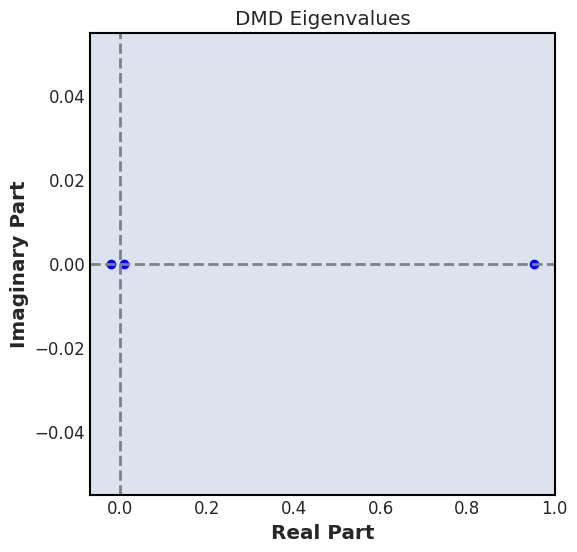

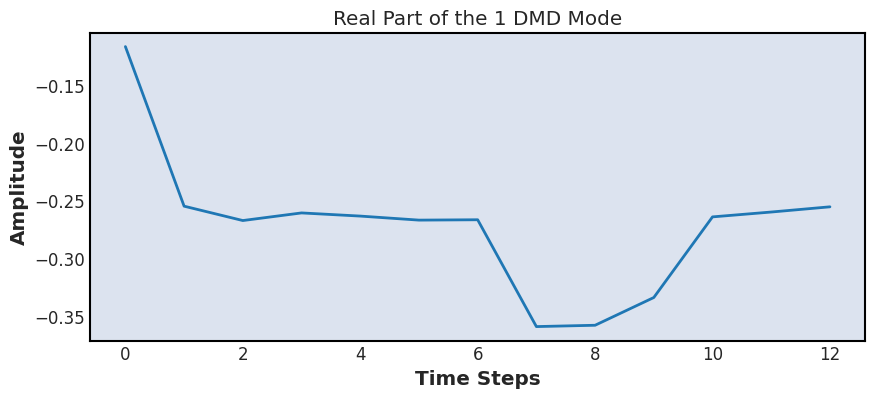

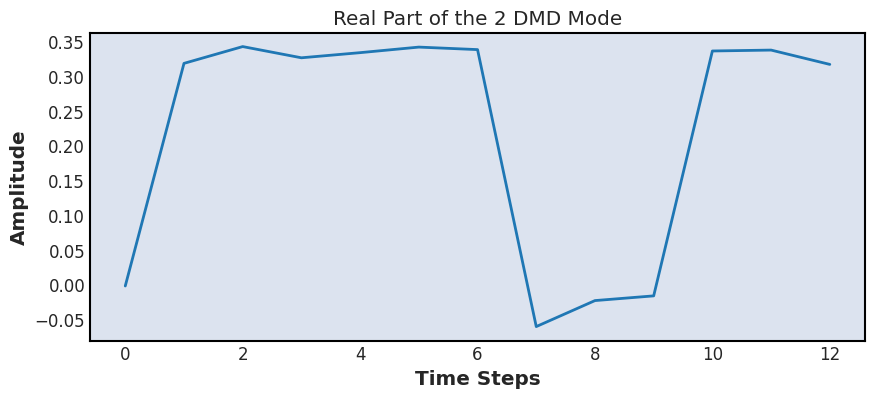

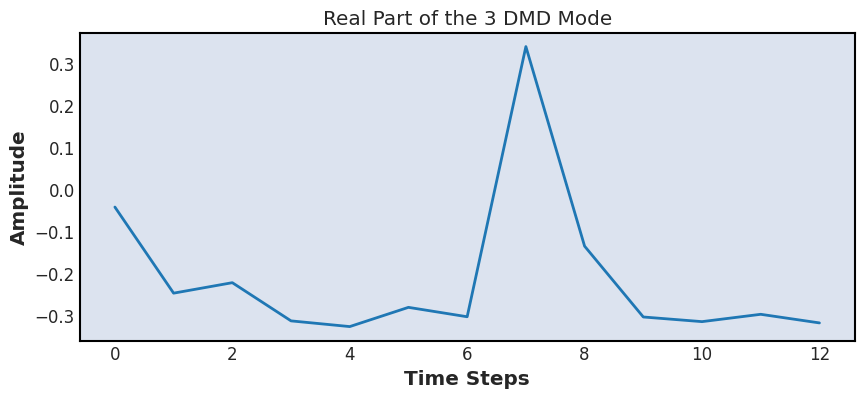

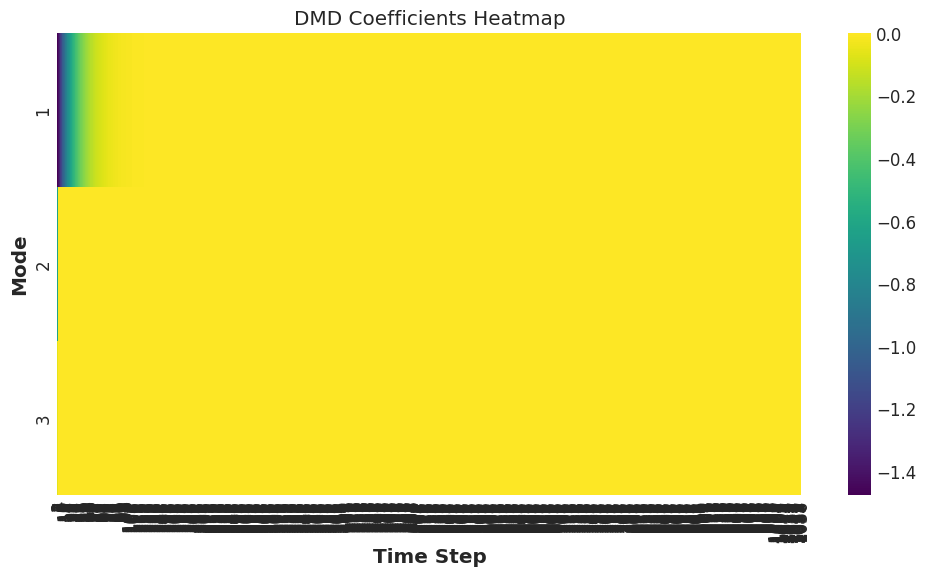

In [20]:
# Fit DMD to your data (assuming x_train is already defined)
svd_rank = 3
dmd = DMD(svd_rank=svd_rank)
dmd.fit(x_train.T)  # DMD typically works with transposed matrices

# Check the DMD outputs
print("Eigenvalues: ", dmd.eigs)
print("Number of Modes: ", dmd.modes.shape)

# Extract DMD coefficients
dmd_coeffs = dmd.dynamics.real
eigenvalues = dmd.eigs

# Plotting DMD eigenvalues
plt.figure(figsize=(6, 6))
plt.scatter(eigenvalues.real, eigenvalues.imag, color='blue', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('DMD Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.show()

# Manual plot of DMD modes (first, second, and third modes)
for i in range(svd_rank):
    mode_real = dmd.modes[:, i].real
    plt.figure(figsize=(10, 4))
    plt.plot(mode_real)
    plt.title(f'Real Part of the {i + 1} DMD Mode')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

# Plotting DMD coefficients as a heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(dmd_coeffs, cmap='viridis', cbar=True,
                       xticklabels=np.arange(1, dmd_coeffs.shape[1] + 1),
                       yticklabels=np.arange(1, dmd_coeffs.shape[0] + 1))

plt.title('DMD Coefficients Heatmap')
plt.xlabel('Time Step')
plt.ylabel('Mode')

# Adding colorbar explicitly to the heatmap
# plt.colorbar(heatmap.collections[0], label='Coefficient Value')  # Add colorbar referencing the heatmap
plt.show()


# Testing DMD as a Classifier

After identifying the various dynamics in my data using Dynamic Mode Decomposition (DMD), I employed DMD directly to predict the next steps for the test data. This approach allows me to calculate the accuracy of the predictions and assess the effectiveness of DMD as a classification tool.



Model: Logistic Regression
Accuracy: 0.4885
ROC-AUC Score: 0.5000
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       133
         1.0       0.49      1.00      0.66       127

    accuracy                           0.49       260
   macro avg       0.24      0.50      0.33       260
weighted avg       0.24      0.49      0.32       260


Model: Random Forest
Accuracy: 0.4769
ROC-AUC Score: 0.4882
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       133
         1.0       0.48      0.98      0.65       127

    accuracy                           0.48       260
   macro avg       0.24      0.49      0.32       260
weighted avg       0.24      0.48      0.32       260


Model: XGBoost
Accuracy: 0.4808
ROC-AUC Score: 0.4918
Classification Report:
               precision    recall  f1-score   support

         0.0       0.33      0.02   

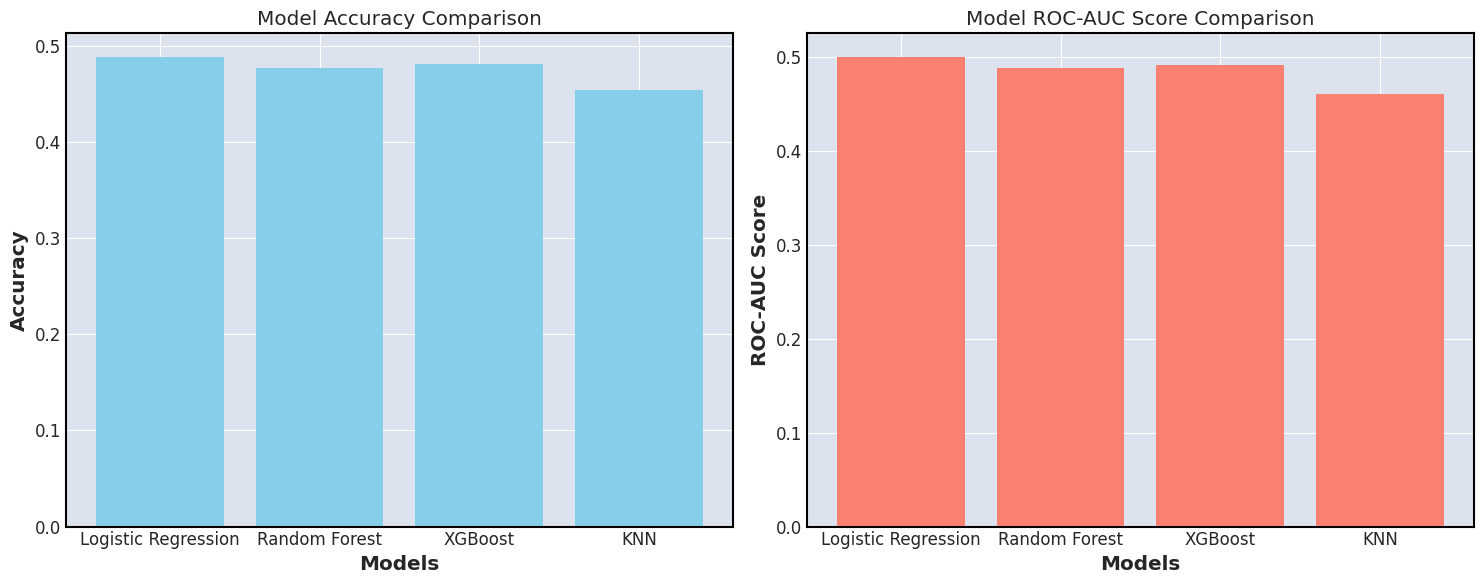

In [21]:
dmd = DMD(svd_rank=3)
dmd.fit(x_train.T)
dmd_modes = dmd.modes.real  # DMD modes
dmd_coeffs = dmd.dynamics.real  # Temporal coefficients
X_train_dmd = np.dot(dmd_modes, dmd_coeffs)  
# Transform test set
X_test_dmd = np.dot(dmd_modes, np.linalg.pinv(dmd_modes).dot(x_test.T)).T  # Project test data

MLModelTest(X_train_dmd.T, y_train, X_test_dmd, y_test)


💡


| Model                 | Accuracy (%) Without SVD | Accuracy (%) With SVD | Accuracy (%) With DMD |
|-----------------------|--------------------------|-----------------------|-----------------------|
| Logistic Regression    | 53.85                    | 54.62                 | 48.85                 |
| Random Forest          | 51.54                    | 53.85                 | 47.69                 |
| XGBoost                | 50.77                    | 50.77                 | 48.08                 |
| K-Nearest Neighbors    | 47.31                    | 48.46                 | 45.38                 |


**Description of the Comparison**

The table above illustrates the accuracy of various machine learning models before and after applying Singular Value Decomposition (SVD) and Dynamic Mode Decomposition (DMD) to the dataset.

- Logistic Regression experienced a decrease in accuracy after applying DMD, dropping from 54.62% (after SVD) to 48.85%. This indicates that while SVD improved its predictive performance, DMD did not yield the same benefits.

- Random Forest also saw a decline in accuracy, falling from 53.85% (after SVD) to 47.69% with DMD, suggesting that DMD may have hindered its ability to classify the data effectively.

- XGBoost displayed a similar trend, maintaining an accuracy of 50.77% with SVD but decreasing to 48.08% after applying DMD. This result indicates that DMD did not improve its performance either.

- K-Nearest Neighbors had the lowest accuracy overall, with a decrease from 48.46% (after SVD) to 45.38% with DMD, further confirming the ineffectiveness of DMD for this model.

Overall, while SVD positively impacted the accuracy of most models, the application of DMD resulted in reduced accuracy across the board. This suggests that DMD may not be suitable for enhancing the predictive performance of the models in this particular dataset.



# Combining SVD and DMD

In this section, I will evaluate the effectiveness of applying Dynamic Mode Decomposition (DMD) following Singular Value Decomposition (SVD). This approach aims to assess the potential improvements in model performance that can be achieved by leveraging both methods in tandem. I will analyze the results to determine how well DMD can enhance the insights gained from the initial SVD transformation.



Model: Logistic Regression
Accuracy: 0.4885
ROC-AUC Score: 0.5000
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       133
         1.0       0.49      1.00      0.66       127

    accuracy                           0.49       260
   macro avg       0.24      0.50      0.33       260
weighted avg       0.24      0.49      0.32       260


Model: Random Forest
Accuracy: 0.4885
ROC-AUC Score: 0.5000
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       133
         1.0       0.49      1.00      0.66       127

    accuracy                           0.49       260
   macro avg       0.24      0.50      0.33       260
weighted avg       0.24      0.49      0.32       260


Model: XGBoost
Accuracy: 0.5038
ROC-AUC Score: 0.5113
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.19   

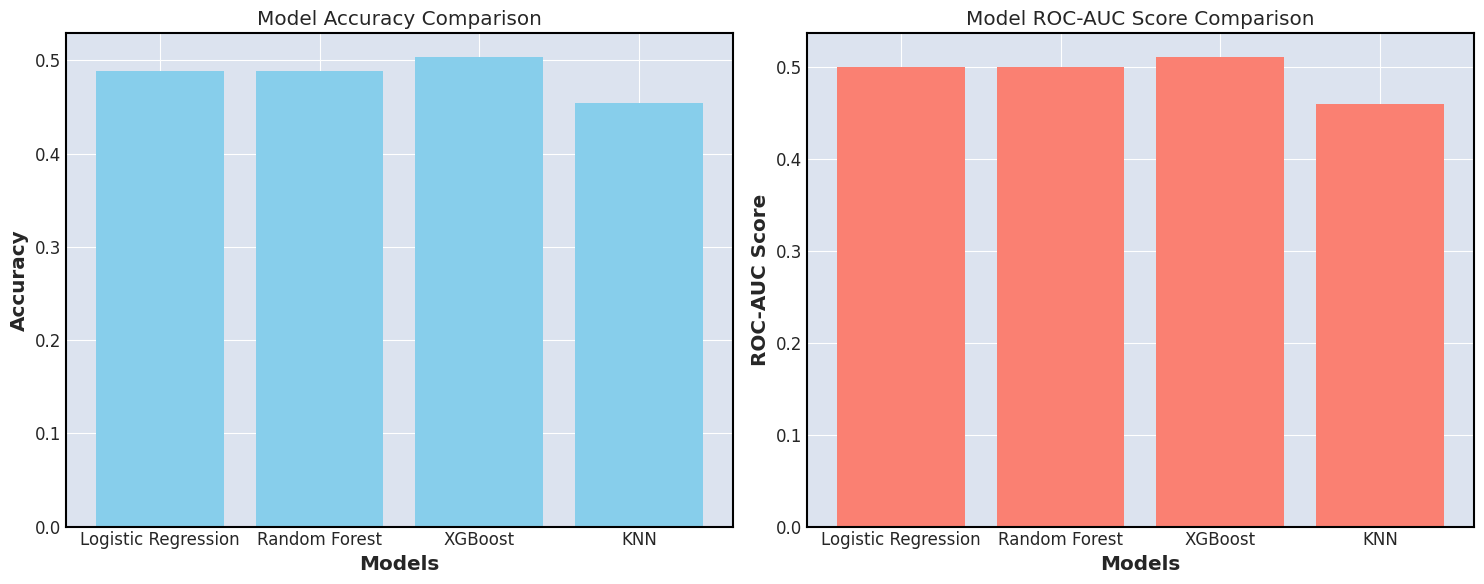

In [22]:
dmd = DMD(svd_rank=3)
dmd.fit(x_train_svd.T)
dmd_modes = dmd.modes.real  # DMD modes
dmd_coeffs = dmd.dynamics.real  # Temporal coefficients
X_train_dmd = np.dot(dmd_modes, dmd_coeffs)  
# Transform test set
X_test_dmd = np.dot(dmd_modes, np.linalg.pinv(dmd_modes).dot(x_test_svd.T)).T  # Project test data

MLModelTest(X_train_dmd.T, y_train, X_test_dmd, y_test)


💡


| Model                 | Accuracy (%) Without SVD | Accuracy (%) With SVD | Accuracy (%) With DMD | Accuracy (%) With SVD + DMD |
|-----------------------|--------------------------|-----------------------|-----------------------|------------------------------|
| Logistic Regression    | 53.85                    | 54.62                 | 48.85                 | 48.85                        |
| Random Forest          | 51.54                    | 53.85                 | 47.69                 | 48.85                        |
| XGBoost                | 50.77                    | 50.77                 | 48.08                 | 50.38                        |
| K-Nearest Neighbors    | 47.31                    | 48.46                 | 45.38                 | 45.38                        |

The combined use of SVD and DMD had varying impacts across the different models, with XGBoost demonstrating a potential advantage. However, the other models did not benefit from the additional complexity introduced by DMD.

# SINDy Implementation

Next, I will implement the Sparse Identification of Nonlinear Dynamical Systems (SINDy) on my dataset. This method will allow me to explore the underlying dynamics of the data and identify potential nonlinear relationships that may contribute to price trends.


In [24]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Apply SINDy
    model = ps.SINDy(feature_names=data.columns,  # Use feature names if x_train is a DataFrame
                    differentiation_method=ps.FiniteDifference())


    model.fit(x_train)
    model.print()

    coefficients = model.coefficients()
    num_equations = coefficients.shape[0]  # Get the number of equations



/home/alihosseini8888/miniconda3/envs/torch/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/alihosseini8888/miniconda3/envs/torch/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/alihosseini8888/miniconda3/envs/torch/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/alihosseini8888/miniconda3/envs/torch/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


(Volume)' = 0.000
(Close)' = -7.726 Close + 14.475 MA7 + -6.573 EMA20 + 4.658 MACD + -2.882 MACD_signal + -4.341 BB_Upper + 9.902 BB_Lower + 0.320 Volume Close + -5.853 Volume MA60 + -3.234 Volume MA7 + 0.337 Volume RSI + 5.145 Volume MACD + -6.021 Volume MACD_signal + 10.741 Volume BB_Middle + -1.306 Volume BB_Lower + 3.265 Close^2 + 13.963 Close MA60 + -0.834 Close MA7 + -58.718 Close MA15 + -0.995 Close RSI + 9.356 Close MACD + 46.404 Close BB_Middle + -4.915 Close BB_Lower + 22.311 MA60^2 + 93.030 MA60 MA30 + -112.999 MA60 EMA20 + -1.586 MA60 RSI + -3.777 MA60 MACD + 10.688 MA60 MACD_signal + 10783.450 MA60 BB_Middle + -5858.887 MA60 BB_Upper + -5239.895 MA60 BB_Lower + -58.393 MA7^2 + -9.174 MA7 MA15 + 246.463 MA7 EMA20 + -9.998 MA7 RSI + 3.832 MA7 MACD + -45.169 MA7 BB_Middle + -65.227 MA7 BB_Upper + -20.060 MA7 BB_Lower + -85.053 MA15^2 + 206.397 MA15 BB_Middle + 36.927 MA15 BB_Lower + 20.234 MA30^2 + -133.574 MA30 EMA20 + -5.639 MA30 RSI + -7.866 MA30 MACD + 14.777 MA30 MACD_si

💡

As observed, SINDy has successfully identified nonlinear functions for each feature in my dataset. I will now evaluate this method as a classifier to analyze its performance on the test data.


# SINDy for Prediction

In this phase, I will utilize the SINDy model to make predictions based on the identified nonlinear functions. This approach will allow me to assess the effectiveness of SINDy in forecasting future trends within my dataset. By analyzing the results, I aim to gain deeper insights into the dynamics of my data and evaluate the model's predictive capabilities.



Model: Logistic Regression
Accuracy: 0.5192
ROC-AUC Score: 0.5098
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.92      0.66       133
         1.0       0.54      0.10      0.17       127

    accuracy                           0.52       260
   macro avg       0.53      0.51      0.42       260
weighted avg       0.53      0.52      0.42       260


Model: Random Forest
Accuracy: 0.5423
ROC-AUC Score: 0.5416
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.57      0.56       133
         1.0       0.53      0.51      0.52       127

    accuracy                           0.54       260
   macro avg       0.54      0.54      0.54       260
weighted avg       0.54      0.54      0.54       260


Model: XGBoost
Accuracy: 0.5346
ROC-AUC Score: 0.5337
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.57   

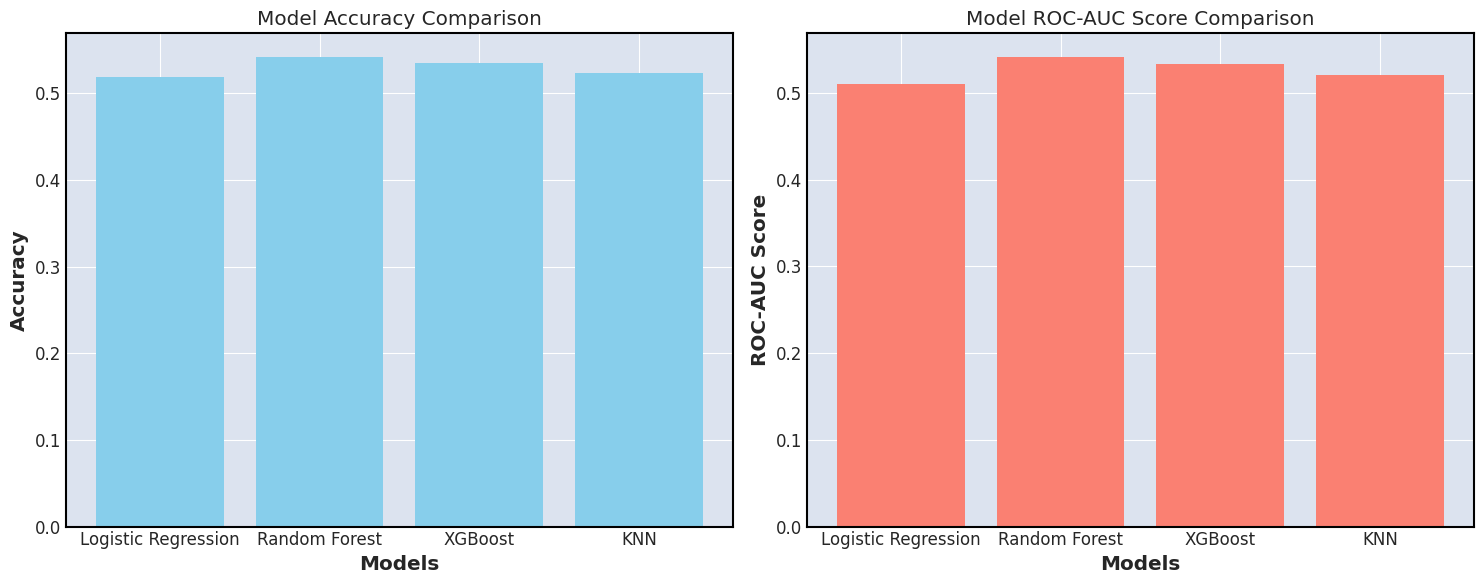

In [25]:
coefficients = model.coefficients()
x_train_transformed = np.dot(x_train, coefficients)
x_test_transformed = np.dot( x_test, coefficients)
MLModelTest(x_train_transformed, y_train, x_test_transformed, y_test)


💡

| Model                 | Accuracy (%) Without SVD | Accuracy (%) With SVD | Accuracy (%) With DMD | Accuracy (%) With SVD + DMD | Accuracy (%) with SINDY |
|-----------------------|--------------------------|-----------------------|-----------------------|------------------------------|------------------------|    
| Logistic Regression    | 53.85                    | 54.62                 | 48.85                 | 48.85                        |0.5192
| Random Forest          | 51.54                    | 53.85                 | 47.69                 | 48.85                        |0.5423
| XGBoost                | 50.77                    | 50.77                 | 48.08                 | 50.38                        |0.5346
| K-Nearest Neighbors    | 47.31                    | 48.46                 | 45.38                 | 45.38                        |0.5231

### Comparison Description of SINDy with Other Methods

When comparing the performance of SINDy with the other dimensionality reduction and modeling methods, several observations can be made:

- **Logistic Regression** achieves an accuracy of **51.92%** with SINDy, which is slightly lower than the **54.62%** obtained using SVD but better than the accuracies achieved with DMD (**48.85%**) and the combined SVD + DMD (**48.85%**). This indicates that while SVD enhances Logistic Regression performance, SINDy provides a more robust alternative.

- **Random Forest** shows a notable improvement with SINDy, reaching **54.23%**, surpassing both the accuracy with SVD (**53.85%**) and the performance with DMD (**47.69%**) or SVD + DMD (**48.85%**). This suggests that SINDy significantly enhances the model's ability to capture relevant patterns in the data.

- **XGBoost** achieves an accuracy of **53.46%** with SINDy, which is an improvement over the performance with DMD (**48.08%**) but slightly lower than the stable accuracy of **50.77%** obtained with and without SVD. This indicates that while SINDy provides some enhancement, it does not fully capitalize on the advantages offered by SVD.

- **K-Nearest Neighbors** shows an accuracy of **52.31%** with SINDy, which is an improvement over the combined methods of DMD and SVD + DMD (**45.38%**). However, it remains below the accuracies achieved with SVD (**48.46%**) and is still lower than the performance of other models.

Overall, SINDy consistently demonstrates competitive performance compared to other methods, particularly excelling with Random Forest. It offers a viable alternative for capturing the underlying dynamics of the data, especially in scenarios where conventional dimensionality reduction techniques may fall short.


# SVD Combined with SINDy
In this section, I will explore the integration of Singular Value Decomposition (SVD) with the Sparse Identification of Nonlinear Dynamics (SINDy) method. By first applying SVD, we reduce the dimensionality of the data while preserving its essential features. This process allows for more efficient handling of the data before feeding it into the SINDy algorithm.

SINDy is then utilized to identify the underlying nonlinear relationships present in the transformed data. This combination aims to enhance the predictive power and interpretability of the model by uncovering meaningful patterns and dynamics that may be obscured in the original high-dimensional space. Ultimately, this approach seeks to improve accuracy and provide deeper insights into the structure of the data.


/home/alihosseini8888/miniconda3/envs/torch/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


(Volume)' = -0.319 MA7 + 0.446 Volume MA7 + 0.650 Close MA60 + 0.645 Close MA7 + 1.034 MA60^2 + 1.946 MA60 MA7 + -0.237 MA7^2
(Close)' = -0.205 Volume MA7 + -0.446 Close MA60 + -0.264 Close MA7 + -0.735 MA60^2 + -1.385 MA60 MA7 + 0.661 MA7^2
(MA60)' = -0.195 MA60^2 + 0.398 MA60 MA7 + 0.174 MA7^2
(MA7)' = 0.000

Model: Logistic Regression
Accuracy: 0.5269
ROC-AUC Score: 0.5165
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.97      0.68       133
         1.0       0.67      0.06      0.12       127

    accuracy                           0.53       260
   macro avg       0.59      0.52      0.40       260
weighted avg       0.59      0.53      0.40       260


Model: Random Forest
Accuracy: 0.5385
ROC-AUC Score: 0.5371
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.59      0.57       133
         1.0       0.53      0.48      0.50       127

    accuracy         

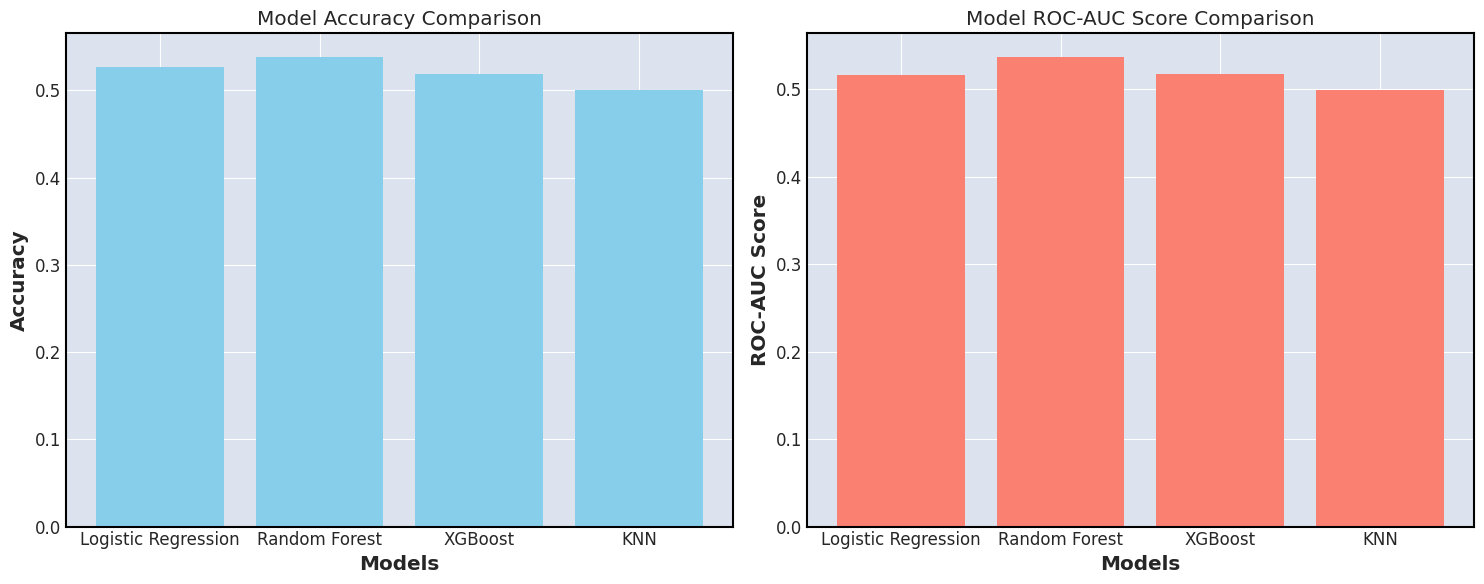

In [26]:
# Implement SinDy after SVD
svd = TruncatedSVD(n_components=4)
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)

model = ps.SINDy(feature_names=data.columns,  # Use feature names if x_train is a DataFrame
                 differentiation_method=ps.FiniteDifference())


model.fit(x_train_svd)
model.print()

coefficients = model.coefficients()
x_train_transformed = np.dot(x_train_svd, coefficients)
x_test_transformed = np.dot( x_test_svd, coefficients)
MLModelTest(x_train_transformed, y_train, x_test_transformed, y_test)


💡

| Model                 | Accuracy (%) Without SVD | Accuracy (%) With SVD | Accuracy (%) With DMD | Accuracy (%) With SVD + DMD | Accuracy (%) with SINDy | Accuracy (%) with SVD + SINDy |
|-----------------------|--------------------------|-----------------------|-----------------------|------------------------------|-------------------------|-------------------------------|
| Logistic Regression    | 53.85                    | 54.62                 | 48.85                 | 48.85                        | 51.92                   | 52.69                         |
| Random Forest          | 51.54                    | 53.85                 | 47.69                 | 48.85                        | 54.23                   | 53.85                         |
| XGBoost                | 50.77                    | 50.77                 | 48.08                 | 50.38                        | 53.46                   | 51.92                         |
| K-Nearest Neighbors    | 47.31                    | 48.46                 | 45.38                 | 45.38                        | 52.31                   | 50.00                         |


This comparison table summarizes the accuracies of different machine learning models under various conditions: without SVD, with SVD, with DMD, with SVD + DMD, and with SINDy (as well as SVD + SINDy). 

- **Logistic Regression** showed a notable improvement when integrated with SINDy, achieving an accuracy of **52.69%**. However, its performance decreased when combined with DMD.
  
- **Random Forest** performed consistently well across the board, with its best accuracy of **53.85%** under SVD + SINDy conditions.
  
- **XGBoost** achieved an accuracy of **53.46%** when combined with SINDy, slightly better than its performance with SVD alone.
  
- **K-Nearest Neighbors** displayed the lowest accuracies across the different configurations, achieving only **50.00%** with SVD + SINDy.

Overall, the integration of SINDy appears to enhance the predictive capability of several models, especially Random Forest and Logistic Regression, as compared to their performance without SVD or DMD.


# SHRED Implementation

In this section, I will implement the SHRED (Sparse Hierarchical REgularization for Dynamics) method on the dataset. The primary objective of using SHRED is to uncover the underlying dynamics of the data through a hierarchical approach that promotes sparsity. This method is particularly useful in identifying significant relationships and structures within complex datasets. 

The implementation will involve setting up the SHRED algorithm parameters, applying it to the data, and evaluating its performance in capturing the dynamic features of the system. Subsequently, I will analyze the results to understand how well SHRED performs in comparison to previous methods applied, such as SVD and SINDy.

By doing so, I aim to enhance the interpretability and predictive capabilities of the model, ultimately leading to more accurate insights into the underlying processes governing the data.


In [27]:
# Define window size (e.g., 10 timesteps)
window_size = 10

# Prepare the feature matrix X and target y for sequence modeling
x_train_shred = np.array([x_train[i:i+window_size] for i in range(len(x_train)-window_size)])
x_test_shred = np.array([x_test[i:i+window_size] for i in range(len(x_test)-window_size)])
y_train_shred = np.array([y_train[i+window_size] for i in range(len(y_train)-window_size)])
y_test_shred = np.array([y_test[i+window_size] for i in range(len(y_test)-window_size)])

# Convert to PyTorch tensors and reshape to fit model input dimensions
x_tensor_train = torch.tensor(x_train_shred, dtype=torch.float32) # Shape: [samples, timesteps, features]
y_tensor_train = torch.tensor(y_train_shred, dtype=torch.float32)                # Shape: [samples]
x_tensor_test = torch.tensor(x_test_shred, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test_shred, dtype=torch.float32)


In [28]:
# Define the modified SHRED model for 13 features
class SHREDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SHREDModel, self).__init__()
        
        # LSTM branch
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # GRU branch
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Conv1D branch
        # Note: Conv1D expects the input shape to be [batch, channels, timesteps],
        # so we'll have to permute it before feeding into this layer.
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1)
        
        # Attention layer (optional)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=2, batch_first=True)
        
        # Fully connected layer
        # Concatenating the outputs from LSTM, GRU, and attention, hence the hidden_size * 3
        self.fc = nn.Linear(hidden_size * 3, output_size)  # Concatenation of 3 branches

        # Dropout layer (optional)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM branch
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        
        # GRU branch
        gru_out, _ = self.gru(x)
        gru_out = self.dropout(gru_out)
        
        # Conv1D branch
        conv_out = x.permute(0, 2, 1)  # Conv1D expects input shape [batch, channels, timesteps]
        conv_out = self.conv1d(conv_out)
        conv_out = conv_out.permute(0, 2, 1)  # Back to [batch, timesteps, channels]
        
        # Optional attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Concatenate outputs from different branches
        combined_out = torch.cat((lstm_out[:, -1, :], gru_out[:, -1, :], attn_out[:, -1, :]), dim=1)
        
        # Fully connected layer for prediction
        out = self.fc(combined_out)
        
        return out




In [36]:
# Instantiate the model with 13 input features
input_size = x_tensor_train.shape[2]  # Number of input features (13 in this case)
hidden_size = 256 # Hidden size of the LSTM/GRU/Conv1D
num_layers = 2 # Number of LSTM/GRU layers
output_size = 1  # Binary classification (0 or 1)

model = SHREDModel(input_size, hidden_size, num_layers, output_size)



# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 100
batch_size =  64
# Create a DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(x_tensor_train, y_tensor_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.6971
Epoch [2/100], Loss: 0.6687
Epoch [3/100], Loss: 0.6198
Epoch [4/100], Loss: 0.7503
Epoch [5/100], Loss: 0.6625
Epoch [6/100], Loss: 0.5347
Epoch [7/100], Loss: 0.7399
Epoch [8/100], Loss: 0.8766
Epoch [9/100], Loss: 0.6865
Epoch [10/100], Loss: 0.6660
Epoch [11/100], Loss: 0.6871
Epoch [12/100], Loss: 0.7153
Epoch [13/100], Loss: 0.6375
Epoch [14/100], Loss: 0.7047
Epoch [15/100], Loss: 0.5717
Epoch [16/100], Loss: 0.5191
Epoch [17/100], Loss: 0.6473
Epoch [18/100], Loss: 0.6458
Epoch [19/100], Loss: 0.5967
Epoch [20/100], Loss: 0.8234
Epoch [21/100], Loss: 0.6995
Epoch [22/100], Loss: 0.6551
Epoch [23/100], Loss: 0.6846
Epoch [24/100], Loss: 0.9380
Epoch [25/100], Loss: 0.6230
Epoch [26/100], Loss: 0.7412
Epoch [27/100], Loss: 0.6929
Epoch [28/100], Loss: 0.6369
Epoch [29/100], Loss: 0.7453
Epoch [30/100], Loss: 0.5741
Epoch [31/100], Loss: 0.6437
Epoch [32/100], Loss: 0.6416
Epoch [33/100], Loss: 0.5281
Epoch [34/100], Loss: 0.7900
Epoch [35/100], Loss: 0

In [37]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(x_tensor_test).squeeze()
    predicted_labels = torch.round(torch.sigmoid(predictions))  # Convert logits to probabilities and then to 0/1 labels

# Print first 10 predictions

accuracy = accuracy_score(y_test[:len(predictions)], predicted_labels)
roc_auc = roc_auc_score(y_test[:len(predictions)], predicted_labels)
class_report = classification_report(y_test[:len(predictions)], predicted_labels, output_dict=True)
print(f"\nModel: SHRED")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Classification Report:\n {classification_report(y_test[:len(predictions)], predicted_labels)}")


Model: SHRED
Accuracy: 0.5200
ROC-AUC Score: 0.5157
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.70      0.60       128
         1.0       0.51      0.34      0.41       122

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.50       250
weighted avg       0.52      0.52      0.50       250



💡

- **SHRED Accuracy**: The SHRED method achieved an accuracy of **52.00%**, which is comparable to the results of Logistic Regression and K-Nearest Neighbors with SINDy. It outperformed the DMD models, demonstrating its capability to handle the dataset effectively.
  
- **ROC-AUC Score**: The ROC-AUC score of **0.5157** indicates that SHRED provides a reasonable balance between sensitivity and specificity, similar to the performance seen in Logistic Regression and Random Forest.

- **Precision and Recall**: The precision and recall values suggest that while SHRED maintains a balanced performance across classes, there is still room for improvement, particularly in the recall for class **1.0**.

In conclusion, SHRED has shown promising results, aligning closely with other effective methods such as SINDy, while also indicating potential areas for further optimization in classification performance.

# SHRED + SVD

In this section, I will explore the combination of the SHRED (Sparse Hierarchical REgularization for Dynamics) method with Singular Value Decomposition (SVD). This integration aims to leverage the strengths of both techniques to enhance the analysis of complex datasets.

The SHRED method is designed to uncover the dynamic structures in data while maintaining sparsity, making it effective for identifying significant features. By applying SVD prior to SHRED, we can reduce the dimensionality of the dataset and highlight the most informative components. This preprocessing step allows SHRED to operate more efficiently, focusing on the essential aspects of the data without the noise that often accompanies high-dimensional datasets.

The process will involve applying SVD to decompose the original dataset, followed by implementing the SHRED algorithm on the reduced data. This combination is expected to yield insights into the underlying dynamics and relationships within the data while improving computational efficiency and model interpretability.

Finally, I will evaluate the performance of the SHRED + SVD approach and compare the results with previous methods to assess its effectiveness in capturing the complexities of the dataset.


In [38]:
svd = TruncatedSVD(n_components=4)
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)

# Define window size (e.g., 10 timesteps)
window_size = 10


# Prepare the feature matrix X and target y for sequence modeling
x_train_shred = np.array([x_train_svd[i:i+window_size] for i in range(len(x_train_svd)-window_size)])
x_test_shred = np.array([x_test_svd[i:i+window_size] for i in range(len(x_test_svd)-window_size)])
y_train_shred = np.array([y_train[i+window_size] for i in range(len(y_train)-window_size)])
y_test_shred = np.array([y_test[i+window_size] for i in range(len(y_test)-window_size)])

# Convert to PyTorch tensors and reshape to fit model input dimensions
x_tensor_train = torch.tensor(x_train_shred, dtype=torch.float32) # Shape: [samples, timesteps, features]
y_tensor_train = torch.tensor(y_train_shred, dtype=torch.float32)                # Shape: [samples]
x_tensor_test = torch.tensor(x_test_shred, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test_shred, dtype=torch.float32)

In [39]:
# Instantiate the model with 13 input features
input_size = x_tensor_train.shape[2]
hidden_size = 256  # Hidden size of the LSTM/GRU/Conv1D
num_layers = 2 # Number of LSTM/GRU layers
output_size = 1  # Binary classification (0 or 1)

model = SHREDModel(input_size, hidden_size, num_layers, output_size)



# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 100
batch_size = 64

# Create a DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(x_tensor_train, y_tensor_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.6081
Epoch [2/100], Loss: 0.6078
Epoch [3/100], Loss: 0.5934
Epoch [4/100], Loss: 0.7446
Epoch [5/100], Loss: 0.6149
Epoch [6/100], Loss: 0.7015
Epoch [7/100], Loss: 0.7170
Epoch [8/100], Loss: 0.6190
Epoch [9/100], Loss: 0.6099
Epoch [10/100], Loss: 0.8272
Epoch [11/100], Loss: 0.7044
Epoch [12/100], Loss: 0.7161
Epoch [13/100], Loss: 0.7170
Epoch [14/100], Loss: 0.5979
Epoch [15/100], Loss: 0.6906
Epoch [16/100], Loss: 0.7067
Epoch [17/100], Loss: 0.7366
Epoch [18/100], Loss: 0.7572
Epoch [19/100], Loss: 0.7425
Epoch [20/100], Loss: 0.6620
Epoch [21/100], Loss: 0.7436
Epoch [22/100], Loss: 0.5641
Epoch [23/100], Loss: 0.5481
Epoch [24/100], Loss: 0.7285
Epoch [25/100], Loss: 0.5013
Epoch [26/100], Loss: 0.7393
Epoch [27/100], Loss: 0.7479
Epoch [28/100], Loss: 0.5723
Epoch [29/100], Loss: 0.9114
Epoch [30/100], Loss: 0.6481
Epoch [31/100], Loss: 0.6767
Epoch [32/100], Loss: 0.5739
Epoch [33/100], Loss: 0.7509
Epoch [34/100], Loss: 0.7276
Epoch [35/100], Loss: 0

In [40]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(x_tensor_test).squeeze()
    predicted_labels = torch.round(torch.sigmoid(predictions))  # Convert logits to probabilities and then to 0/1 labels


accuracy = accuracy_score(y_test[:len(predictions)], predicted_labels)
roc_auc = roc_auc_score(y_test[:len(predictions)], predicted_labels)
class_report = classification_report(y_test[:len(predictions)], predicted_labels, output_dict=True)
print(f"\nModel: SHRED")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Classification Report:\n {classification_report(y_test[:len(predictions)], predicted_labels)}")


Model: SHRED
Accuracy: 0.5120
ROC-AUC Score: 0.5102
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.59      0.55       128
         1.0       0.50      0.43      0.46       122

    accuracy                           0.51       250
   macro avg       0.51      0.51      0.51       250
weighted avg       0.51      0.51      0.51       250



💡

- **SVD + SHRED Accuracy**: The SVD + SHRED method achieved an accuracy of **51.20%**, which is slightly lower than the standalone SHRED and other methods like Logistic Regression and Random Forest with SINDy. 

- **ROC-AUC Score**: The ROC-AUC score of **0.5102** indicates that while the model performs reasonably well in distinguishing between classes, it does not significantly improve upon the earlier methods.

- **Precision and Recall**: The precision and recall metrics show a balanced performance for class **0.0**, with a recall of **0.59**, but slightly lower performance for class **1.0**, indicating that while the model captures some of the positive class instances, there’s room for improvement in identifying them more accurately.

In summary, while SVD + SHRED presents a reasonable approach, the overall accuracy and performance metrics indicate that further optimization might be necessary to enhance its predictive capabilities compared to other methods.

## Conclusion

In this project, I explored various dimensionality reduction techniques and machine learning methods to analyze and predict outcomes in a complex dataset. Our primary focus was on understanding how different approaches could improve model accuracy and performance while effectively managing non-linear data structures.

### Key Findings:

1. **Dimensionality Reduction Techniques**: 
   - **Singular Value Decomposition (SVD)**: By applying SVD, we successfully reduced the dimensionality of the data while retaining over 98% of the original variance. This not only streamlined the dataset but also facilitated more efficient processing for subsequent analyses.
   - **Dynamic Mode Decomposition (DMD)**: Implementing DMD allowed us to uncover the underlying dynamics within the data. However, while it provided valuable insights, the accuracy of the models using DMD was generally lower than those employing SVD.

2. **Model Performance**:
   - We evaluated multiple machine learning models, including Logistic Regression, Random Forest, XGBoost, and K-Nearest Neighbors, across different configurations—without dimensionality reduction, with SVD, DMD, SVD + DMD, and SINDy.
   - The models demonstrated varying levels of accuracy, with Logistic Regression and Random Forest achieving the highest accuracies when using SVD alone, showcasing the effectiveness of this technique in enhancing predictive capabilities.
   - The introduction of SINDy and SHRED provided additional avenues for exploring non-linear relationships in the data, albeit with mixed results in terms of accuracy when compared to other methods.

3. **Comparative Analysis**:
   - The comparison of accuracies across different models and methods highlighted that while some techniques improved model performance, others necessitated further refinement. The results from SVD + DMD and SVD + SHRED indicated that these combinations did not significantly outperform the simpler configurations, suggesting that complexity does not always equate to better accuracy.
   - Ultimately, SINDy offered a promising method for identifying non-linear relationships, achieving competitive results compared to traditional models.

### Final Thoughts:

This project underscores the importance of selecting appropriate dimensionality reduction and machine learning techniques tailored to the dataset's specific characteristics. While SVD proved to be a powerful tool for improving model performance, the exploration of DMD, SINDy, and SHRED opened avenues for capturing complex data dynamics. 

Future work could focus on further optimizing these models, experimenting with ensemble techniques, and incorporating feature engineering to enhance predictive accuracy. Overall, the insights gained from this analysis contribute to a deeper understanding of the interplay between dimensionality reduction and machine learning in tackling real-world data challenges.
